#Learning a generative model for trajectories based on test data

After analysing the transformations and parameters for the sequences in the test data for the tracking task, it is possible to learn a generative model using that information. The trajectories for the synthetic sequences may be sampled from the learnt model, with the advantage of being realistic trajectories. Gaussian Mixture Models (GMM) are the selected generative model, trained using scikit-learn implementation. Samples will be taken from the test data trajectories and used to train the model. With the learnt model, samples are going to be drawn to move the objects on the synthetic sequences.

In [44]:
%pylab inline --no-import-all
import numpy
import sklearn.mixture
import pickle
from PIL import Image, ImageDraw
import animator
import IPython.display
import os

Populating the interactive namespace from numpy and matplotlib


##Preprocessing the trajectories

The trajectories are going to be sampled with a prespecified constant length (60) using only 4 features corresponding to translation and scaling. The samples will be generated densely, so the frame offset between samples is 1. 

In [83]:
#Parameters of sample trajectories and accumulator
LENGTH = 60
N_FEATURES = 4
OFFSET = 1
SEQ_DIR = '/home/fmpaezri/datasets/vot-challenge/sequences/'

First, we load and show the raw parameters for the test trajectories.

In [74]:
def plot_params(path, xTicks=None, create=True):
    '''Plots the parameters of a given sequence'''
    titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $', '$ \\theta_{pv}$', 'product', 'ratio']
    if create:
        matplotlib.pyplot.figure()
    matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
    for i in range(path.shape[1]):
        axes = matplotlib.pyplot.subplot(int(path.shape[1]/2),2,i+1)
        if xTicks is None:
            xTicks = numpy.arange(path.shape[0])
        matplotlib.pyplot.plot(xTicks, path[:,i])
        if i/2 < int(path.shape[1]/2)-1:
            matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
        matplotlib.pyplot.ylabel(titles[i])

Keys for 25 sequences: ['skating', 'bicycle', 'drunk', 'sphere', 'ball', 'gymnastics', 'hand1', 'hand2', 'diving', 'fish2', 'fish1', 'basketball', 'sunshade', 'polarbear', 'woman', 'bolt', 'surfing', 'tunnel', 'car', 'torus', 'fernando', 'david', 'jogging', 'trellis', 'motocross']


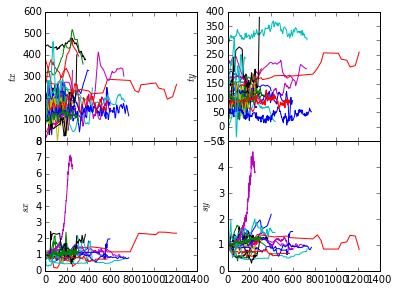

In [75]:
#Load file with dictionary of each sequence trajectory parameters
trajFile = open('trajectoryParams.pkl', 'r')
trajectories = pickle.load(trajFile)
trajFile.close()
print 'Keys for {} sequences: {}'.format(len(trajectories.keys()), trajectories.keys())
[plot_params(trajectory[:,:N_FEATURES], create=False) for trajectory in trajectories.values()];

Now, we are going to apply some scaling to allow a temporal-length independent visualization.

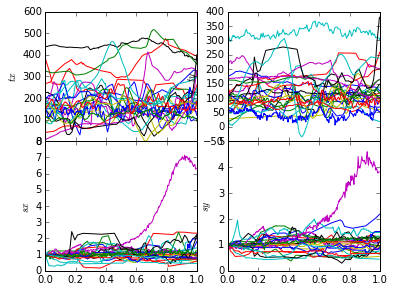

In [81]:
[plot_params(trajectory[:,:N_FEATURES], xTicks=numpy.arange(trajectory.shape[0], dtype=float)/trajectory.shape[0], create=False) for trajectory in trajectories.values()];

Next, a normalized visualization which avoids the model focuses on learning only large magnitude features.

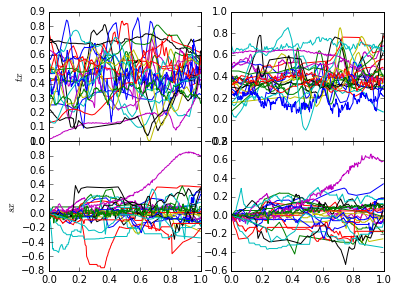

In [94]:
for name, trajectory in trajectories.iteritems():
    sequenceImage = Image.open(os.path.join(SEQ_DIR, name, '00000001.jpg'))
    seqSize = sequenceImage.size
    sequenceImage.close()
    normalizations = lambda x: numpy.vstack([x[:,0]/seqSize[0], x[:,1]/seqSize[1], numpy.log10(x[:,2]), numpy.log10(x[:,3])]).T
    plot_params(normalizations(trajectory[:,:N_FEATURES]), xTicks=numpy.arange(trajectory.shape[0], dtype=float)/trajectory.shape[0], create=False)

In [3]:
def draw_polygon(polygons, size=(640, 480), outlines=['red', 'green', 'blue']):
    '''Draws polygons over an image'''
    image = Image.new('RGBA', size)
    draw = ImageDraw.ImageDraw(image)
    for id, polygon in enumerate(polygons):
        draw.polygon(polygon, outline=outlines[id])
        for i in range(len(polygon)/2):
            draw.text(polygon[2*i:2*i+2], str(i), fill=outlines[id])
    return image

In [4]:
def box_video(output, boxData):
    '''Generates a video drawing the specified polygons'''
    sequence = (draw_polygon([boxes[i] for boxes in boxData]) for i in numpy.arange(len(predictedPointsList)))
    animator.frames2video(sequence, 30, output)
    videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
    videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
    return videoTag.format(videoSrc)

##Trajectory subsampling

As the synthetic sequences are going to be of constant length (60), the input to the model are going to be subsequences of a fixed length. This also helps to have a fixed dimensional input vector. For each of the parameters we take a slice starting on the same frame. These slices are concatenated to obtain the feature vector of LENGTH x N_FEATURES. The offset between samples is going to be of 1.

In [95]:
samples = numpy.empty((LENGTH, N_FEATURES, 0))
print samples.shape
#Trajectory subsampling and original trajectory plots
totalLength = 0
for aSequence in trajectories.keys():
    trajectory = trajectories[aSequence]
    seqSize = Image.open(os.path.join(SEQ_DIR, aSequence, '00000001.jpg')).size
    normalizations = lambda x: numpy.vstack([x[:,0]/seqSize[0], x[:,1]/seqSize[1], numpy.log10(x[:,2]), numpy.log10(x[:,3])]).T
    totalLength += trajectory.shape[0]
    print '{} length and dimensions: {}\t{}'.format(aSequence, trajectory.shape, seqSize)
    #plot_params(trajectory)
    for start in numpy.arange(0, trajectory.shape[0]-LENGTH, OFFSET):
        sample = trajectories[aSequence][start:start+LENGTH,:N_FEATURES]
        sample = normalizations(sample)
        #sample = numpy.vstack([numpy.zeros((1, N_FEATURES)), numpy.diff(sample, axis=0)])
        samples = numpy.dstack([samples, sample])
#samples = samples[:,:,1:]
print 'Total length: {}'.format(totalLength)

(60, 4, 0)
skating length and dimensions: (400, 8)	(640, 360)
bicycle length and dimensions: (271, 8)	(320, 240)
drunk length and dimensions: (1210, 8)	(508, 336)
sphere length and dimensions: (201, 8)	(480, 360)
ball length and dimensions: (603, 8)	(320, 240)
gymnastics length and dimensions: (207, 8)	(320, 180)
hand1 length and dimensions: (244, 8)	(320, 240)
hand2 length and dimensions: (267, 8)	(320, 240)
diving length and dimensions: (219, 8)	(400, 224)
fish2 length and dimensions: (310, 8)	(640, 360)
fish1 length and dimensions: (436, 8)	(460, 259)
basketball length and dimensions: (725, 8)	(576, 432)
sunshade length and dimensions: (172, 8)	(352, 288)
polarbear length and dimensions: (371, 8)	(640, 360)
woman length and dimensions: (597, 8)	(352, 288)
bolt length and dimensions: (350, 8)	(640, 360)
surfing length and dimensions: (282, 8)	(320, 240)
tunnel length and dimensions: (731, 8)	(360, 480)
car length and dimensions: (252, 8)	(640, 272)
torus length and dimensions: (264, 

(60, 4, 8714)
(8714, 240)
0.0


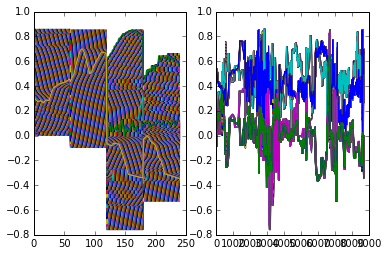

In [102]:
#Shape and reshape debugging 
print samples.shape
flatSample = samples.T.reshape(-1, LENGTH*N_FEATURES)
print flatSample.shape
print (flatSample[0,:].reshape(N_FEATURES, LENGTH).T-samples[0:LENGTH,:,0]).sum()
matplotlib.pyplot.subplot(1,2,1);
matplotlib.pyplot.plot(flatSample.T);
matplotlib.pyplot.subplot(1,2,2);
matplotlib.pyplot.plot(flatSample)
#matplotlib.pyplot.plot(samples[0:LENGTH,:,0].T.ravel());

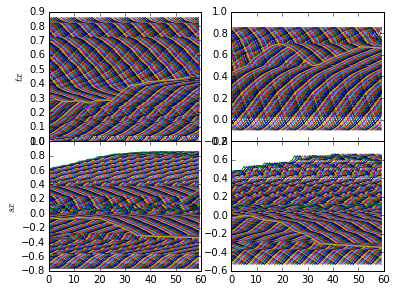

In [129]:
#Plot of samples
#matplotlib.pyplot.plot(flatSample[0].reshape(N_FEATURES, LENGTH).T)
#print flatSample.reshape(-1, LENGTH, N_FEATURES).shape
#matplotlib.pyplot.plot(flatSample.reshape(-1, N_FEATURES, LENGTH).T)
plot_params(flatSample.reshape(-1, N_FEATURES, LENGTH).T, create=False)

##Model training

To reduce the variance we are trying to select a large number of mixtures. Initially we are using 1024 mixtures that in average would be made of 8 samples.

In [130]:
#GMM training and sampling
MIXTURES = 256*4 # samples.shape[-1]/2
gmm = sklearn.mixture.GMM(n_components=MIXTURES, )
%time gmm.fit(flatSample)
%time predictedSamples = gmm.sample(n_samples=MIXTURES*2)

CPU times: user 3min 10s, sys: 0 ns, total: 3min 10s
Wall time: 3min 10s
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 140 ms


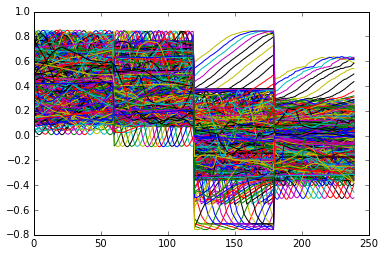

In [131]:
matplotlib.pyplot.plot(gmm.means_.T);

Sample index: 1836


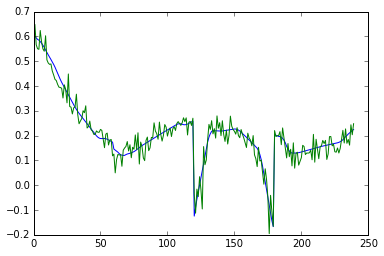

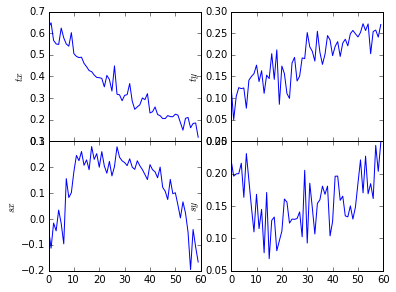

In [148]:
#Select a sample and plot boxes
sampleIndex = numpy.random.choice(predictedSamples.shape[0])
print 'Sample index: {}'.format(sampleIndex)
predictedSample = predictedSamples[sampleIndex,:].reshape(N_FEATURES, LENGTH).T
cluster = gmm.predict(predictedSample.T.ravel())[0]
matplotlib.pyplot.plot(gmm.means_[cluster])
matplotlib.pyplot.plot(predictedSample.T.ravel())
plot_params(predictedSample)
predictedPointsList = []
refPoints = numpy.array([[0,100,100,0],[0,0,100,100],[1,1,1,1]])
sceneSize = (640, 320)
#for tx, ty, sx, sy, theta, origTheta, product, ratio in predictedSample:
for tx, ty, sx, sy in predictedSample:
    theta = 0
    tx *= sceneSize[0]
    ty *= sceneSize[1]
    sx = 10.0**sx
    sy = 10.0**sy
    predictedTransform = numpy.array([[sx*numpy.cos(theta), sy*numpy.sin(theta), tx],[-sx*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
    predictedPoints = numpy.dot(predictedTransform, refPoints)
    predictedPointsList.append(predictedPoints[:2,:].T.flatten())
IPython.display.HTML(box_video('/tmp/video.mp4', [[point.tolist() for point in predictedPointsList]]))

(121,)


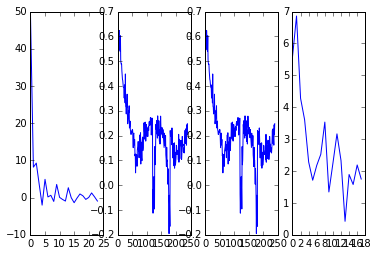

In [149]:
import numpy.fft
#sampleKey = numpy.random.choice(trajectories.keys())
#print sampleKey
data = predictedSample.T.ravel()
#fft = numpy.fft.rfft(trajectories[sampleKey][:,0])
fft = numpy.fft.rfft(data)
matplotlib.pyplot.subplot(1,4,1)
matplotlib.pyplot.plot(fft[:int(fft.shape[0]/5)])
matplotlib.pyplot.subplot(1,4,2)
matplotlib.pyplot.plot(data)
matplotlib.pyplot.subplot(1,4,3)
matplotlib.pyplot.plot(numpy.fft.irfft(fft))
matplotlib.pyplot.subplot(1,4,4)
matplotlib.pyplot.plot(numpy.fft.irfft(fft[:10]))
print fft.shape